In [119]:
#!pip install nltk
import nltk
#nltk.download("reuters")

import pandas as pd
from nltk.corpus import reuters
import numpy as np
import matplotlib.pyplot as plt 

from string import punctuation

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, CategoricalNB
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## checking dataset

In [2]:
reuters.categories("training/9865")

['barley', 'corn', 'grain', 'wheat']

In [3]:
reuters.fileids("barley")[50]

'training/9958'

In [4]:
reuters.raw("training/9865")

"FRENCH FREE MARKET CEREAL EXPORT BIDS DETAILED\n  French operators have requested licences\n  to export 675,500 tonnes of maize, 245,000 tonnes of barley,\n  22,000 tonnes of soft bread wheat and 20,000 tonnes of feed\n  wheat at today's European Community tender, traders said.\n      Rebates requested ranged from 127.75 to 132.50 European\n  Currency Units a tonne for maize, 136.00 to 141.00 Ecus a tonne\n  for barley and 134.25 to 141.81 Ecus for bread wheat, while\n  rebates requested for feed wheat were 137.65 Ecus, they said.\n  \n\n"

# 1.	Use appropriate NLTK coding to visualize the number of documents per category in the training set. Is the dataset class balanced? Motivate your answer.

Go through categories and get number of documents in each. Then put them in dataframe.

## Create and visualize number of documents per category

In [5]:
frame = {"category":[], "Num_docs":[]}          # initialize frame with empty lists
for i in reuters.categories():                  # iterate through categories
    documents_num = len(reuters.fileids(i))         # get number of documents/category

    #print(f"{i} has {documents} documents")
    frame["category"].append(i)                 # Append category name and
    frame["Num_docs"].append(documents_num)         # number of documents on approppriate column

data=pd.DataFrame(data=frame)                   # make dataframe fr
#data["category_id"] = data["category"].factorize()[0] 
data # check data


,category,Num_docs
0,acq,2369
1,alum,58
2,barley,51
3,bop,105
4,carcass,68
...,...,...
85,veg-oil,124
86,wheat,283
87,wpi,29
88,yen,59


Plot bar graph with matplotlib and annotate categories that have more than 400 documents (name only these to keep plot readable)

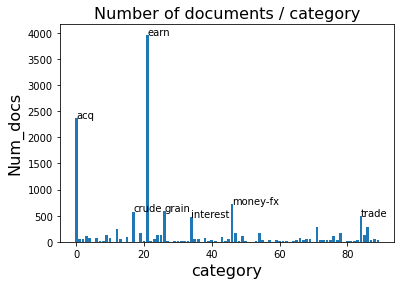

In [6]:
# make new dataframe from rows which num_docs >= 400 to annotate
df = data.query('Num_docs >= 400')

# bar plot with matplotlib in Python
plt.bar(data.index, data.Num_docs, alpha=1)   

# iterate through index
for i in df.index:                                      
    plt.annotate(data.iloc[i,0], (i,data.iloc[i,1]))    # add categories names to datapoints which are >= 400

# set x-axis label and specific size
plt.xlabel('category',size=16)                          
# set y-axis label and specific size
plt.ylabel('Num_docs',size=16)
# set plot title with specific size
plt.title('Number of documents / category',size=16)
# save the plot as PNG file with dpi=150
#plt.savefig('docs_per_category.png', dpi=150)
plt.show()

# 2. Construct the feature set using CountVectorizer of the training dataset so that the maximum size of the feature set is 100 and each word feature should be contained in at least 3 documents and in less than 70% of total documents to be considered. Use standard preprocessing and stopword list, with WordNet lemmatizer.

## Preprosessor (not used Now)

In [7]:
# preprosessor (not used)

def preProcess(doc):
    WN_lemmatizer = WordNetLemmatizer()

    sentences = sent_tokenize(doc)
    Tokens = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        words = [WN_lemmatizer.lemmatize(word, pos="v") for word in words]
        Tokens.extend(words)
        
    return ' '.join(Tokens)

## Make function to apply CountVectorizer and fit

In [8]:
# Use class to define tokenizer that also applies WordNetLemmatizer to CountVectorizer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [227]:
# define countVectrizer and fit

def BOW_model(train_data, test_data, max_features):
    """Return feature vectors from CounVectorizer"""
    BOW = CountVectorizer(tokenizer=LemmaTokenizer(), 
                          lowercase=True, 
                          max_features = max_features, 
                          stop_words = "english", 
                          min_df = 3, max_df = 0.7)
    # fit train data
    BOW.fit(train_data)
    BOW_train = BOW.transform(train_data)
    BOW_test = BOW.transform(test_data)
 
    #print(BOW.get_feature_names())
    return (BOW_train.toarray(), BOW_test.toarray())

## Extract data from reuters Dataset and divide to pre determined Training and Test variables

In [10]:
# select fileid
doc_list = np.array(reuters.fileids())

# create test and train IDs from documents
test_doc = doc_list[['test' in x for x in doc_list]]

train_doc = doc_list[['training' in x for x in doc_list]]

## Get labels ( categories ) for each document and create Dataframes

In [11]:

def create_df(data, **kwargs):
    """Create DataFrames to visualise data a bit and duplicate multi-categorial documents so that they have just one category but appear multiple times.
    - data: list of documents (e.g. train and test data)
    - rm_punct: remove punctuation. default: False 
    - words: Join reuters words to str instead of using raw text. Default: True"""
    rm_punct = kwargs.get("rm_punct", False)
    words = kwargs.get("words", True)

    docs=[]
    for ids in data:
        cats = reuters.categories(ids)      # At each iteration we retrieve categories of an id
        if words is True:
            doc = " ".join(reuters.words(ids))  # join words from each document
        else:
            doc = reuters.raw(ids)              # get raw text data of document
        if rm_punct is True:
            for punct in (punctuation + "\n"):  # go through punctuations 
                doc = doc.replace(punct, "")    # remove punctuation
        for cat in cats:
            docs.append((doc, cat, ids)) # These documents are appended as a tuple (document, category, ids) in the list
    
    # docs=[(" ".join(reuters.words(ids)), cat, ids) for ids in train_doc for cat in reuters.categories(ids)] # list comprehension for loop

    df=pd.DataFrame(docs, columns=['document', 'category','ids']) # The data frame is created using the generated tuple.

    #df # check dataframe
    return df

# train_df["ids"].duplicated().value_counts() # checks how many duplicates because of categories


In [39]:
train_df2 = create_df(train_doc, rm_punct=True, words=False)
train_df2

,document,category,ids
0,BAHIA COCOA REVIEW Showers continued througho...,cocoa,training/1
1,COMPUTER TERMINAL SYSTEMS ltCPML COMPLETES SAL...,acq,training/10
2,NZ TRADING BANK DEPOSIT GROWTH RISES SLIGHTLY ...,money-supply,training/100
3,NATIONAL AMUSEMENTS AGAIN UPS VIACOM ltVIA BID...,acq,training/1000
4,ROGERS ltROG SEES 1ST QTR NET UP SIGNIFICANTLY...,earn,training/10000
...,...,...,...
9579,UK MONEY MARKET SHORTAGE FORECAST REVISED DOWN...,money-fx,training/999
9580,KNIGHTRIDDER INC ltKRN SETS QUARTERLY Qtly di...,earn,training/9992
9581,TECHNITROL INC ltTNL SETS QUARTERLY Qtly div ...,earn,training/9993
9582,NATIONWIDE CELLULAR SERVICE INC ltNCEL 4TH QTR...,earn,training/9994


In [40]:
train_df = create_df(train_doc)
train_df

,document,category,ids
0,BAHIA COCOA REVIEW Showers continued throughou...,cocoa,training/1
1,COMPUTER TERMINAL SYSTEMS & lt ; CPML > COMPLE...,acq,training/10
2,N . Z . TRADING BANK DEPOSIT GROWTH RISES SLIG...,money-supply,training/100
3,NATIONAL AMUSEMENTS AGAIN UPS VIACOM & lt ; VI...,acq,training/1000
4,ROGERS & lt ; ROG > SEES 1ST QTR NET UP SIGNIF...,earn,training/10000
...,...,...,...
9579,U . K . MONEY MARKET SHORTAGE FORECAST REVISED...,money-fx,training/999
9580,KNIGHT - RIDDER INC & lt ; KRN > SETS QUARTERL...,earn,training/9992
9581,TECHNITROL INC & lt ; TNL > SETS QUARTERLY Qtl...,earn,training/9993
9582,NATIONWIDE CELLULAR SERVICE INC & lt ; NCEL > ...,earn,training/9994


In [41]:
test_df2 = create_df(test_doc, rm_punct=True, words=False)
test_df2

,document,category,ids
0,ASIAN EXPORTERS FEAR DAMAGE FROM USJAPAN RIFT ...,trade,test/14826
1,CHINA DAILY SAYS VERMIN EAT 712 PCT GRAIN STOC...,grain,test/14828
2,JAPAN TO REVISE LONGTERM ENERGY DEMAND DOWNWAR...,crude,test/14829
3,JAPAN TO REVISE LONGTERM ENERGY DEMAND DOWNWAR...,nat-gas,test/14829
4,THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Th...,corn,test/14832
...,...,...,...
3739,TOKYO DEALERS SEE DOLLAR POISED TO BREACH 140 ...,money-fx,test/21573
3740,TOKYO DEALERS SEE DOLLAR POISED TO BREACH 140 ...,yen,test/21573
3741,JAPANINDIA CONFERENCE CUTS GULF WAR RISK CHARG...,ship,test/21574
3742,SOVIET INDUSTRIAL GROWTHTRADE SLOWER IN 1987 ...,ipi,test/21575


In [42]:
test_df = create_df(test_doc)
test_df

,document,category,ids
0,ASIAN EXPORTERS FEAR DAMAGE FROM U . S .- JAPA...,trade,test/14826
1,CHINA DAILY SAYS VERMIN EAT 7 - 12 PCT GRAIN S...,grain,test/14828
2,JAPAN TO REVISE LONG - TERM ENERGY DEMAND DOWN...,crude,test/14829
3,JAPAN TO REVISE LONG - TERM ENERGY DEMAND DOWN...,nat-gas,test/14829
4,THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Tha...,corn,test/14832
...,...,...,...
3739,TOKYO DEALERS SEE DOLLAR POISED TO BREACH 140 ...,money-fx,test/21573
3740,TOKYO DEALERS SEE DOLLAR POISED TO BREACH 140 ...,yen,test/21573
3741,JAPAN / INDIA CONFERENCE CUTS GULF WAR RISK CH...,ship,test/21574
3742,SOVIET INDUSTRIAL GROWTH / TRADE SLOWER IN 198...,ipi,test/21575


In [16]:
# Save data as csv

with open('./train_data.csv', 'a' ,encoding='utf-8') as csvFile:
        train_df.to_csv(csvFile, mode='a', index=False, encoding="utf-8", sep=',')

with open('./test_data.csv', 'a' ,encoding='utf-8') as csvFile:
        test_df.to_csv(csvFile, mode='a', index=False, encoding="utf-8", sep=',')

## Get Feature vectors from documents

In [228]:
features_train, features_test = BOW_model(train_df["document"], test_df["document"], 100)

C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [229]:
print(features_train)

[[0 0 0 ... 3 0 2]
 [3 2 0 ... 0 0 1]
 [0 1 0 ... 0 0 4]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]]


# 3. Use NaivesBayes classifier to generate the model and test it on the testing dataset. Output the accuracy and F1 measure of this classifier. Compare the result with Random Forest and linear SVM classifiers.


## NaiveBayes Classifier

In [202]:
# Create a Gaussian NaiveBayes Classifier
gnb = GaussianNB()

# Create a Multinomial NaiveBayes Classifier
mnb = MultinomialNB()

# Create a Complement NaiveBayes Classifier
cnb = ComplementNB()


In [203]:
# Fit/train the NaiveBayes model
classifier = gnb.fit(features_train, train_df["category"])
#classifier = nltk.NaiveBayesClassifier.train(train_df["category"], features_train)
#?nltk.NaiveBayesClassifier

In [204]:
# Make predictions
expected = test_df["category"]
predicted = classifier.predict(features_test)

In [205]:
# Output the accuracy and F1 measure of this classifier
print("accuracy = ", metrics.accuracy_score(expected, predicted))
accuracy_nb = metrics.accuracy_score(expected, predicted)
print("f1 score = ", metrics.f1_score(expected, predicted, average = "weighted"))
f1_nb = metrics.f1_score(expected, predicted, average = "weighted")

accuracy =  0.3020833333333333
f1 score =  0.328185983931604


In [206]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

                 precision    recall  f1-score   support

            acq       0.95      0.07      0.13       719
           alum       0.00      0.00      0.00        23
         barley       0.05      0.14      0.07        14
            bop       0.31      0.13      0.19        30
        carcass       0.11      0.11      0.11        18
     castor-oil       0.00      0.00      0.00         1
          cocoa       0.12      0.11      0.12        18
        coconut       0.00      0.00      0.00         2
    coconut-oil       0.00      0.00      0.00         3
         coffee       0.00      0.00      0.00        28
         copper       0.01      0.06      0.02        18
     copra-cake       0.00      0.00      0.00         1
           corn       0.00      0.00      0.00        56
         cotton       0.00      0.00      0.00        20
     cotton-oil       0.00      0.00      0.00         2
            cpi       0.00      0.00      0.00        28
            cpu       0.00    

C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## RandomForestClassifier

In [207]:
# Create RandomForestClassifier
rfc = RandomForestClassifier() # n_estimators=100, random_state=0

# Train RFC model
RFC_classifier = rfc.fit(features_train, train_df["category"])

In [208]:
predicted = RFC_classifier.predict(features_test)
expected = test_df["category"]
#print(metrics.classification_report(expected, predicted))
#print(metrics.confusion_matrix(expected, predicted))

In [209]:
# Output the accuracy and F1 measure of this classifier
print("accuracy = ", metrics.accuracy_score(expected, predicted))
accuracy_rf = metrics.accuracy_score(expected, predicted)
print("f1 score = ", metrics.f1_score(expected, predicted, average = "weighted"))
f1_rf = metrics.f1_score(expected, predicted, average = "weighted")


accuracy =  0.6573183760683761
f1 score =  0.61118793522863


##  Linear SVM classifier

In [210]:
# Create SVM Classifier
#svm = SVC(kernel="linear")
svm = LinearSVC()

# Train SVM model
SVM_classifier = svm.fit(features_train, train_df["category"])

C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [211]:
predicted = SVM_classifier.predict(features_test)
expected = test_df["category"]

# Output the accuracy and F1 measure of this classifier
print("accuracy = ", metrics.accuracy_score(expected, predicted))
accuracy_svm = metrics.accuracy_score(expected, predicted)
print("f1 score = ", metrics.f1_score(expected, predicted, average = "weighted"))
f1_svm = metrics.f1_score(expected, predicted, average = "weighted")

accuracy =  0.6271367521367521
f1 score =  0.5953823037342557


In [212]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

                 precision    recall  f1-score   support

            acq       0.76      0.95      0.85       719
           alum       0.17      0.04      0.07        23
         barley       0.17      0.07      0.10        14
            bop       0.44      0.27      0.33        30
        carcass       0.14      0.06      0.08        18
     castor-oil       0.00      0.00      0.00         1
          cocoa       0.11      0.33      0.17        18
        coconut       0.00      0.00      0.00         2
    coconut-oil       0.00      0.00      0.00         3
         coffee       0.28      0.18      0.22        28
         copper       0.27      0.17      0.21        18
     copra-cake       0.00      0.00      0.00         1
           corn       0.34      0.20      0.25        56
         cotton       0.00      0.00      0.00        20
     cotton-oil       0.00      0.00      0.00         2
            cpi       0.21      0.11      0.14        28
            cpu       0.00    

C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## List results

In [213]:
results_100 = [(accuracy_nb, f1_nb), (accuracy_rf, f1_rf), (accuracy_svm, f1_svm)]
results_100_df = pd.DataFrame(results_100, columns=['acc', 'f1'], index=["nb","rf", "svm"])
results_100_df

,acc,f1
nb,0.302083,0.328186
rf,0.657318,0.611188
svm,0.627137,0.595382


# 4. Show the results of this classifier when the total number of features varies as 1000, 1500, 2000, 2500, 3000, 3500, 4500, 5000.

## Create function to apply classifier

In [215]:
# funtion to apply NaiveBayes classifier, print and return accuracy and f1-value

def nb_classifier(features_train,features_test):
    """ funtion to apply NaiveBayes classifier, print and return accuracy and f1-value """

    # Fit/train the gaussian NaiveBayes model
    classifier = gnb.fit(features_train, train_df["category"])

    # Make predictions
    expected = test_df["category"]
    predicted = classifier.predict(features_test)

    # summarize the fit of the model
    #print(metrics.classification_report(expected, predicted))
    #print(metrics.confusion_matrix(expected, predicted))

    ##Output the accuracy and F1 measure of this classifier
    accuracy_nb = metrics.accuracy_score(expected, predicted)
    print("accuracy: ", accuracy_nb)
    f1_nb = metrics.f1_score(expected, predicted, average = "weighted")
    print("f1 score: ", f1_nb)
    return (accuracy_nb, f1_nb)



In [216]:
def rf_classifier(features_train,features_test):

    # Create RandomForestClassifier
    rfc = RandomForestClassifier()

    # Train RFC model
    classifier = rfc.fit(features_train, train_df["category"])

    # make predictions
    predicted = classifier.predict(features_test)
    expected = test_df["category"]

    # summarize the fit of the model
    #print(metrics.classification_report(expected, predicted))
    #print(metrics.confusion_matrix(expected, predicted))

    # Output the accuracy and F1 measure of this classifier
    print("accuracy = ", metrics.accuracy_score(expected, predicted))
    accuracy_rf = metrics.accuracy_score(expected, predicted)
    print("f1 score = ", metrics.f1_score(expected, predicted, average = "weighted"))
    f1_rf = metrics.f1_score(expected, predicted, average = "weighted")

    return (accuracy_rf, f1_rf)

In [217]:
def svm_classifier(features_train,features_test):

    # Get feature vectors
    #BOW_train = BOW_model(train_df["document"], features)
    #BOW_test = BOW_model(test_df["document"], features)

    # Create SVM Classifier
    #svm = SVC(kernel="linear")
    svm = LinearSVC()

    # Train SVM model
    classifier = svm.fit(features_train, train_df["category"])
    predicted = classifier.predict(features_test)
    expected = test_df["category"]

    # summarize the fit of the model
    #print(metrics.classification_report(expected, predicted))
    #print(metrics.confusion_matrix(expected, predicted))

    # Output the accuracy and F1 measure of this classifier
    print("accuracy = ", metrics.accuracy_score(expected, predicted))
    accuracy_svm = metrics.accuracy_score(expected, predicted)
    print("f1 score = ", metrics.f1_score(expected, predicted, average = "weighted"))
    f1_svm = metrics.f1_score(expected, predicted, average = "weighted")

    return (accuracy_svm, f1_svm)


## Apply function

### BOW models

In [230]:
# use all numbers of vectors
num_vec = [100,1000,1500,2000,2500,3000,3500,4500,5000]
# list for feature vectors
feature_vecs = []

# iterate through numbers
for num in num_vec:
   # make feature vectors as tuples (train, test) and append to list
   feature_vecs.append(BOW_model(train_df["document"], test_df["document"], num))

   

### NaiveBayes

In [231]:
# add results list
results = []

# iterate through feature vectors
for vec in feature_vecs:
    # apply classifier and append results to list: train = 0 , test = 1
    results.append(nb_classifier(vec[0],vec[1]))
    #print(vec[1])

nb_results_df = pd.DataFrame(results, columns=['acc', 'f1'], index=["nb_100", "nb_1000", "nb_1500", "nb_2000", "nb_2500", "nb_3000", "nb_3500", "nb_4500", "nb_5000"])


accuracy:  0.3020833333333333
f1 score:  0.328185983931604
accuracy:  0.46474358974358976
f1 score:  0.47853470142336146
accuracy:  0.4893162393162393
f1 score:  0.48816383074814185
accuracy:  0.4986645299145299
f1 score:  0.4889780283897969
accuracy:  0.5066773504273504
f1 score:  0.4913354975927903
accuracy:  0.5061431623931624
f1 score:  0.4847744672665356
accuracy:  0.5016025641025641
f1 score:  0.4758435581141394
accuracy:  0.5189636752136753
f1 score:  0.4901192029066765
accuracy:  0.5192307692307693
f1 score:  0.48981709356670483


In [232]:
nb_results_df

,acc,f1
nb_100,0.302083,0.328186
nb_1000,0.464744,0.478535
nb_1500,0.489316,0.488164
nb_2000,0.498665,0.488978
nb_2500,0.506677,0.491335
nb_3000,0.506143,0.484774
nb_3500,0.501603,0.475844
nb_4500,0.518964,0.490119
nb_5000,0.519231,0.489817


<AxesSubplot:>

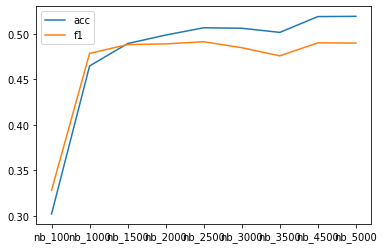

In [235]:
nb_results_df.plot()

### Random Forest

In [236]:
results = []

for vec in feature_vecs:
    results.append(rf_classifier(vec[0],vec[1]))
    #print(results)

rf_results_df = pd.DataFrame(results, columns=['acc', 'f1'], index=["rf_100", "rf_1000", "rf_1500", "rf_2000", "rf_2500", "rf_3000", "rf_3500", "rf_4500", "rf_5000"])


accuracy =  0.6575854700854701
f1 score =  0.6124231214576051
accuracy =  0.7059294871794872
f1 score =  0.6634036882450864
accuracy =  0.7051282051282052
f1 score =  0.6634995014426958
accuracy =  0.7019230769230769
f1 score =  0.6580174702951579
accuracy =  0.7032585470085471
f1 score =  0.6590135443728801
accuracy =  0.7021901709401709
f1 score =  0.6593178162897887
accuracy =  0.6992521367521367
f1 score =  0.6537066547828023
accuracy =  0.6984508547008547
f1 score =  0.6524244861479714
accuracy =  0.7003205128205128
f1 score =  0.6585428117715783


<AxesSubplot:>

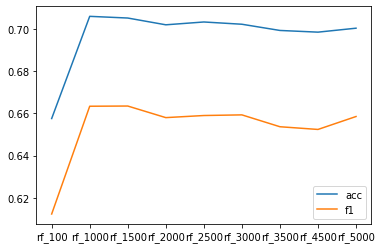

In [237]:
rf_results_df.plot()

### SVM

In [238]:
results = []

for vec in feature_vecs:
    results.append(svm_classifier(vec[0],vec[1]))
    #print(results)

svm_results_df = pd.DataFrame(results, columns=['acc', 'f1'], index=["svm_100", "svm_1000", "svm_1500", "svm_2000", "svm_2500", "svm_3000", "svm_3500", "svm_4500", "svm_5000"])


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy =  0.624465811965812
f1 score =  0.5918649769755463


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy =  0.6984508547008547
f1 score =  0.6823865695440653


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy =  0.7056623931623932
f1 score =  0.6917141171175453


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy =  0.7104700854700855
f1 score =  0.6940218818111283


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy =  0.7150106837606838
f1 score =  0.7010125876318193


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy =  0.7171474358974359
f1 score =  0.7027274483688253


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy =  0.719017094017094
f1 score =  0.7026847873790937


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy =  0.7206196581196581
f1 score =  0.706516300002468
accuracy =  0.7230235042735043
f1 score =  0.7061759362642563


C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


<AxesSubplot:>

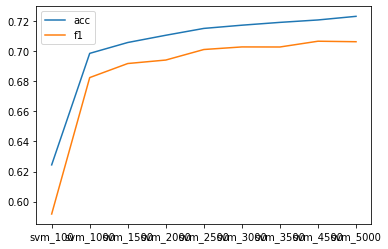

In [239]:
svm_results_df.plot()

## List Results

In [242]:
results_df = pd.DataFrame()
results_df = results_df.append(nb_results_df)
results_df = results_df.append(rf_results_df)
results_df = results_df.append(svm_results_df)
results_df

,acc,f1
nb_100,0.302083,0.328186
nb_1000,0.464744,0.478535
nb_1500,0.489316,0.488164
nb_2000,0.498665,0.488978
nb_2500,0.506677,0.491335
nb_3000,0.506143,0.484774
nb_3500,0.501603,0.475844
nb_4500,0.518964,0.490119
nb_5000,0.519231,0.489817
rf_100,0.657585,0.612423


# 5. Repeat 3) when a PCA (of 95% information preservation) is used to reduce the dimension of the feature space. 


In [244]:
def PCA_model (features_train, features_test):
    pca = PCA(n_components=0.95)
    pca.fit(features_train)
    pca_train = pca.transform(features_train)
    pca_test = pca.transform(features_test)
    return pca_train, pca_test

In [254]:
pca_train, pca_test = PCA_model(features_train, features_test)

# make list of classifier tuples and create dataframe
l = [nb_classifier(pca_train, pca_test)]

pca_df = pd.DataFrame(l, columns=['acc', 'f1'], index=["nb_100"])


accuracy:  0.468482905982906
f1 score:  0.4537237656536132


# 6. Instead of CountVectorizer, use TfidfVectorizer to create the feature set as in 2) and test the classification accuracy and F1 measure of Naives’ Bayes classifier.


# 7. Use Word2vec to create a feature vector to each document by averaging over all word2vec representations of individual words constituting the document. Use this feature set to train the Naives’ Bayes classifier and output the accuracy, F1 measure and confusion matrix on testing data. 


# 8. Now we would like to tackle the discrepancy of the number of instances in training data among the various categories. For this purpose, create a new partition, where you remove the categories that contains very large number of instances and very low number of instances as compared to the rest of the categories. Repeat 3) and provide the results on the table. 

# 9. Similarly, use word2vec model to calculate the new performance on the testing data for the new set of categories in 8).

# 10. Now we would like to handle the data discrepancy in the class, we would like to perform data augmentation on the small size classes. For this purpose, for the classes, which contain small number of instances, write a script that allows you to duplicate the number of small samples at an order close to the average of other classes. Then repeat the process 3) and test whether an enhancement of the results on the testing data can be noticed.
 

# 11. Now we would like to test the influence of the multi-category documents on the classification. For this purpose, write a script, which scrutinizes the training set, so that every document, which is found to belong to more than one category in the training set is removed. Repeat 3) and word2vec model to evaluate the performance of the model on the test data, and discuss the contribution of this removal action. 

# 12. Use appropriate literature in order to comment on your findings. 